# Shadow pricing
- Check metabolite dependency of reactions that were important features in the RF analysis

In [28]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import cobra

In [29]:
# Load models
cd630=cobra.io.read_sbml_model("models/iCdG709.sbml")
r20291=cobra.io.read_sbml_model("models/iCdR703.sbml")

https://identifiers.org/seed.reaction/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


In [6]:
# Load data
sp = pd.read_csv('../data/shadowPrices3.csv').drop(columns = 'Unnamed: 0') # Calculated in riptide.ipynb

In [7]:
# Most important features for RF predictions (taken from fluxSampling3.ipynb)
rf20_3 = ['rxn01446_c',
 'EX_cpd00492_e',
 'rxn05234_c',
 'EX_cpd00567_e',
 'rxn00908_c',
 'rxn00213_c',
 'rxn00611_c',
 'rxn05527_c',
 'rxn08168_c',
 'rxn01799_c',
 'rxn00747_c',
 'rxn05562_c',
 'rxn00182_c',
 'rxn10131_c',
 'rxn00692_c',
 'rxn00258_c',
 'EX_cpd00076_e',
 'rxn00001_c',
 'rxn00297_c',
 'rxn05205_c']

# Summarize shadow pricing (sp) results
- For each objective function: 
1. Get metabolite sp range and median across experimental conditions
2. Scale ranges (0-1)? and set threshold; count metabolites above threshold (# metabolites with variance across conditions)
3. Bin medians (u < 0 : sensitive,  u >= 0 : no change)
4. Plot heat map (objFxn x (variance, sensitive, no change)

In [8]:
r = sp.drop(columns = ['strain', 'condition', 'toxin','OF_name']).groupby(by='OF')
r1 = r.max()-r.min() # ranges for metabolite across all conditions

In [9]:
spsumdf = pd.concat([(r.median()>-0.1).sum(axis = 1) , # Sensitive
                     (r.median()<=-0.1).sum(axis = 1), # Not sensitive
                     (r1 > 2).sum(axis=1), # Ranges
                     sp['OF'].value_counts() ], axis=1) # Number of models w/rxn as OF
sumdf = spsumdf.rename(columns={0:'No Change',1:'Sensitive',2:'Model Variable', 'OF':'Conditions'})

In [10]:
sumdf['name']= ''
for x in rf20_3:
    sumdf.loc[sumdf.index==x, 'name']=str(cd630.reactions.get_by_id(x).name)    

In [11]:
# Sort df and add fraction column
sumdf1 = sumdf.sort_values(by = ['Conditions', 'No Change','Sensitive'], ascending=False) # Sorting
sumdf1['conditionFraction'] = sumdf1['Conditions']/sumdf1['Conditions'].max() # Fraction of models w/feasible solutions for OFs

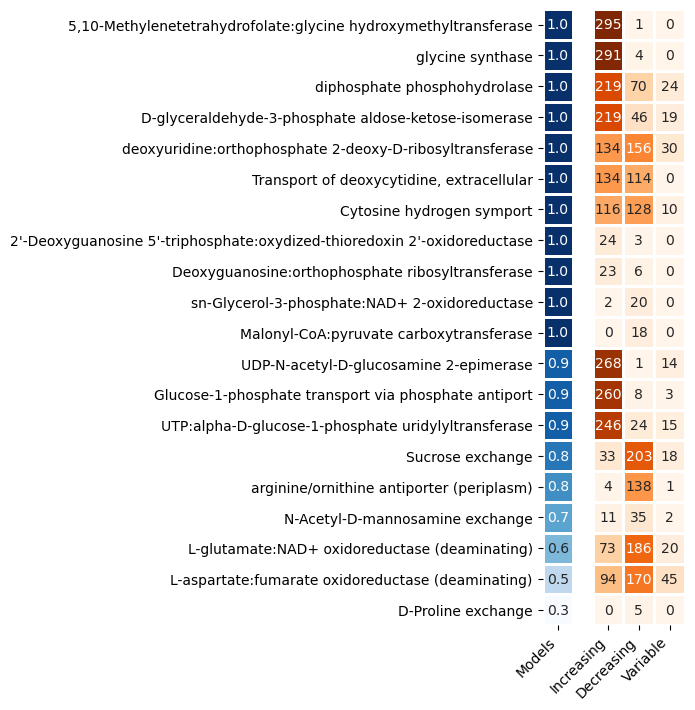

In [39]:
# Make heatmap for data
f, ax = plt.subplots(1,2, sharey=True, figsize=(8, 8))

ax1 = sns.heatmap(sumdf1.iloc[:,5:6],
                 annot=True,
                 fmt='.1f',
                 cmap="Blues",
                 square=True,
                 linewidths=1,
                 cbar=False,
                 ax = ax[0],
                 yticklabels = False,
                 xticklabels = ['Models'])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, ha='right');
ax2 = sns.heatmap(sumdf1.iloc[:,:-3], 
                 annot=True, 
                 fmt="d", 
                 cmap="Oranges", 
                 square=True,
                 linewidths=1,
                 cbar=False,
                 yticklabels=sumdf1['name'],
                  xticklabels=['Increasing','Decreasing','Variable'],
                 ax = ax[1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45, ha='right');
plt.tick_params(axis='y', left = False)
#ax1.set_ylabel("");
plt.subplots_adjust(wspace=-0.85)

#plt.savefig('../figures/spSummary4.jpeg',bbox_inches='tight', dpi = 600)

# Plot metabolite shadow prices 
- Plot sensitive metabolite shadow prices by objective function

In [13]:
longNameDict = {'Undecaprenyl-diphospho-N-acetylmuramoyl--N-acetylglucosamine-L-ala-D-glu-meso-2-6-diaminopimeloyl-D-ala-D-ala':'Undecaprenyl-pyrophosphoryl-MurNAc-pentapeptide',
'Undecaprenyl-diphospho-N-acetylmuramoyl-L-alanyl-D-glutamyl-meso-2-6-diaminopimeloyl-D-alanyl-D-alanine':'Peptidoglycan polymer',
'MurAc(oyl-L-Ala-D-gamma-Glu-L-Lys-D-Ala-D-Ala)-diphospho- undecaprenol':'Undecaprenyldiphospho-N-acetylmuramoyl peptide',
'Undecaprenyl-diphospho-N-acetylmuramoyl-(N-acetylglucosamine)-L-alanyl-gamma-D-glutamyl-L-lysyl-D-alanyl-D-alanine':'Undecaprenyldiphospho-N-acetylmuramoyl peptide II',
'N-Acetyl-beta-D-mannosaminyl-1,4-N-acetyl-D- glucosaminyldiphosphoundecaprenol': 'Polyprenyl phospho oligosaccharide',
'UDP-N-acetylmuramoyl-L-alanyl-D-glutamyl-6-carboxy-L-lysyl-D-alanyl-D-alanine':'UDP-glycopeptide',
'UDPMurAc(oyl-L-Ala-D-gamma-Glu-L-Lys-D-Ala-D-Ala)':'UDP-glycopeptide',
'UDP-N-acetylmuramoyl-L-alanyl-D-gamma-glutamyl-meso-2-6-diaminopimelate':'UDP-N-acetylmuramoyl'
}

In [14]:
spFilter = lambda x: x<-5 # lambda x: x<-5 or x > 1 # Why did I have this??
ofdf = pd.DataFrame()

for OF in rf20_3:
    # Get column names for averages < -5 
    m0 = sp.loc[sp['OF']==OF].iloc[:,5:].median().apply(spFilter)
    m1 = m0[m0].index.to_list()    
    
    # Get averages:
    df = sp.loc[sp['OF']==OF, m1].median().rename(OF)
    ofdf = pd.concat([ofdf,df],axis=1)

In [256]:
# Add metabolite names
ofdf['name']=''
for x in ofdf.index:
    ofdf.loc[x,'name'] = r20291.metabolites.get_by_id(x).name

In [257]:
for x in longNameDict:
    ofdf.loc[ofdf['name']==x, 'name']=str(longNameDict[x])

In [258]:
# Drop columns with zero metabolites below the shadow price sensitivity threshold
ofdf1 = ofdf.dropna(axis=1, how='all')

In [259]:
[print(x, r20291.reactions.get_by_id(x).name) for x in ofdf1.iloc[:,:-1].columns.to_list()]

rxn05527_c Cytosine hydrogen symport
rxn08168_c L-aspartate:fumarate oxidoreductase (deaminating)
rxn01799_c deoxyuridine:orthophosphate 2-deoxy-D-ribosyltransferase
rxn00747_c D-glyceraldehyde-3-phosphate aldose-ketose-isomerase
rxn00182_c L-glutamate:NAD+ oxidoreductase (deaminating)
rxn10131_c arginine/ornithine antiporter (periplasm)
rxn00258_c Malonyl-CoA:pyruvate carboxytransferase
EX_cpd00076_e Sucrose exchange
rxn05205_c Transport of deoxycytidine, extracellular


[None, None, None, None, None, None, None, None, None]

In [260]:
ofdf1.shape # 48 metabolites

(48, 10)

In [261]:
# Calculate reactions sensitive to the most metabolites
mets = (48 - ofdf1.iloc[:,:-1].isna().sum()).sort_values(ascending=False) #59 metabolites total
mets
# Most sensitive reactions: 'arginine/ornithine antiporter (periplasm)' and 'L-aspartate:fumarate oxidoreductase (deaminating)'

rxn10131_c       43
rxn08168_c       42
rxn00182_c       23
rxn00258_c       16
rxn05527_c       12
rxn00747_c       10
EX_cpd00076_e     8
rxn01799_c        3
rxn05205_c        1
dtype: int64

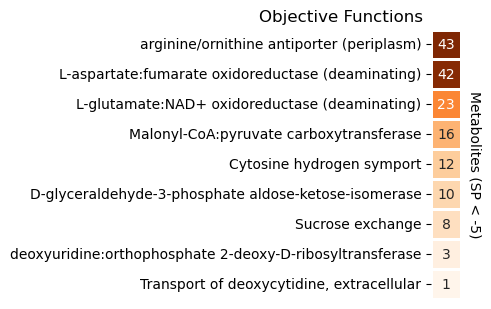

In [267]:
foo = pd.DataFrame(mets)

f,ax = plt.subplots(1,1, figsize=(6,3.5))

ax1 = sns.heatmap(foo,
                 annot=True,
                 fmt='.0f',
                 cmap="Oranges",
                 square=True,
                 linewidths=1,
                 cbar=False,
                 ax = ax,
                 yticklabels = [cd630.reactions.get_by_id(x).name for x in foo.index],
                 xticklabels = False)
ax1.set_ylabel('Metabolites (SP < -5)', rotation=270, labelpad=15)
ax1.yaxis.set_label_position("right")
plt.title('Objective Functions',x=-3, fontsize=12)

#plt.savefig('../figures/sp3_filter1.jpeg',bbox_inches='tight', dpi = 600)

In [268]:
ofdf2 = ofdf1.loc[:,list(mets.index)].sort_values(by = ['rxn10131_c','rxn08168_c','rxn00182_c','rxn05527_c'], ascending=False)

In [269]:
ofdf3 = ofdf2.iloc[:,:2].dropna(axis=0, how='all')

Text(0.5, 0.08, 'Shadow Prices')

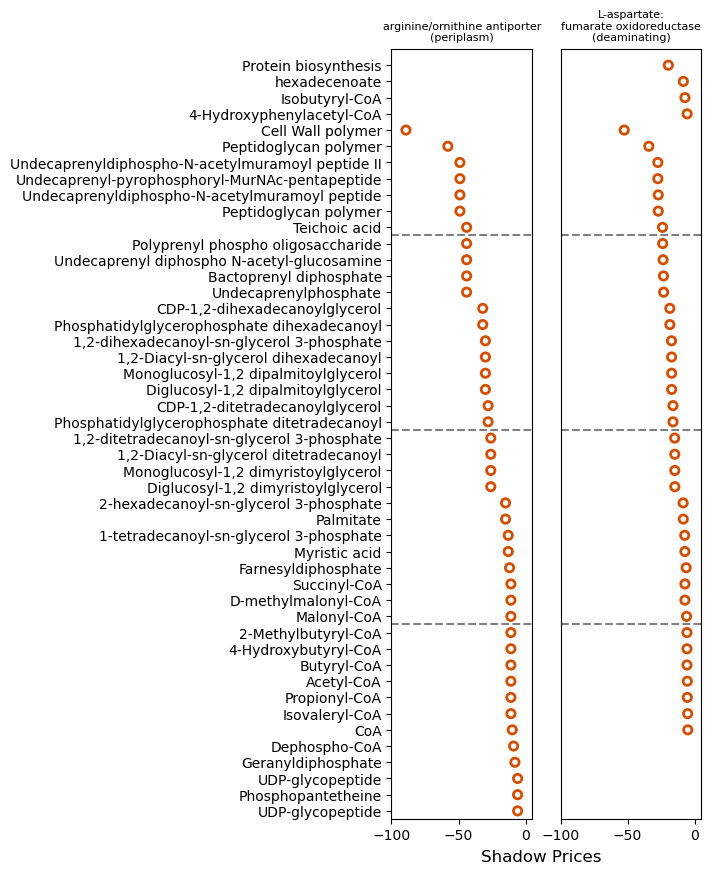

In [270]:
subtitles = ['arginine/ornithine antiporter\n(periplasm)','L-aspartate:\nfumarate oxidoreductase\n(deaminating)']
f, ax = plt.subplots(1,2,figsize=(4,10),sharey=True, sharex=True)

for x,OF in enumerate(ofdf3.columns):
    ax[x].scatter(ofdf3[OF], ofdf3.index, facecolors='none', edgecolors='#d24e01', linewidth = 2)
    ax[x].set_title(subtitles[x], fontsize=8)
    ax[x].axhline(y=11.5, color='grey', linestyle='--')
    ax[x].axhline(y=23.5, color='grey', linestyle='--')
    ax[x].axhline(y=35.5, color='grey', linestyle='--')

# Remove ticks:
for x in range(1,2):
    ax[x].get_yaxis().set_visible(False)
    
locs, labels = plt.yticks()    
plt.yticks(locs,ofdf1.loc[ofdf3.index, 'name'].tolist())  
plt.ylim(-.5, 47)
plt.xlim(-100,5)
plt.suptitle('Shadow Prices', y = 0.08)

#plt.savefig('../figures/spOFL3.jpeg',bbox_inches='tight', dpi = 600)

In [284]:
of2 = ['rxn00182_c','rxn00258_c','rxn05527_c','rxn00747_c','EX_cpd00076_e','rxn01799_c','rxn05205_c']

In [285]:
ofdf4 = ofdf1[of2].dropna(axis=0, how='all').sort_values(by=of2, ascending=False)

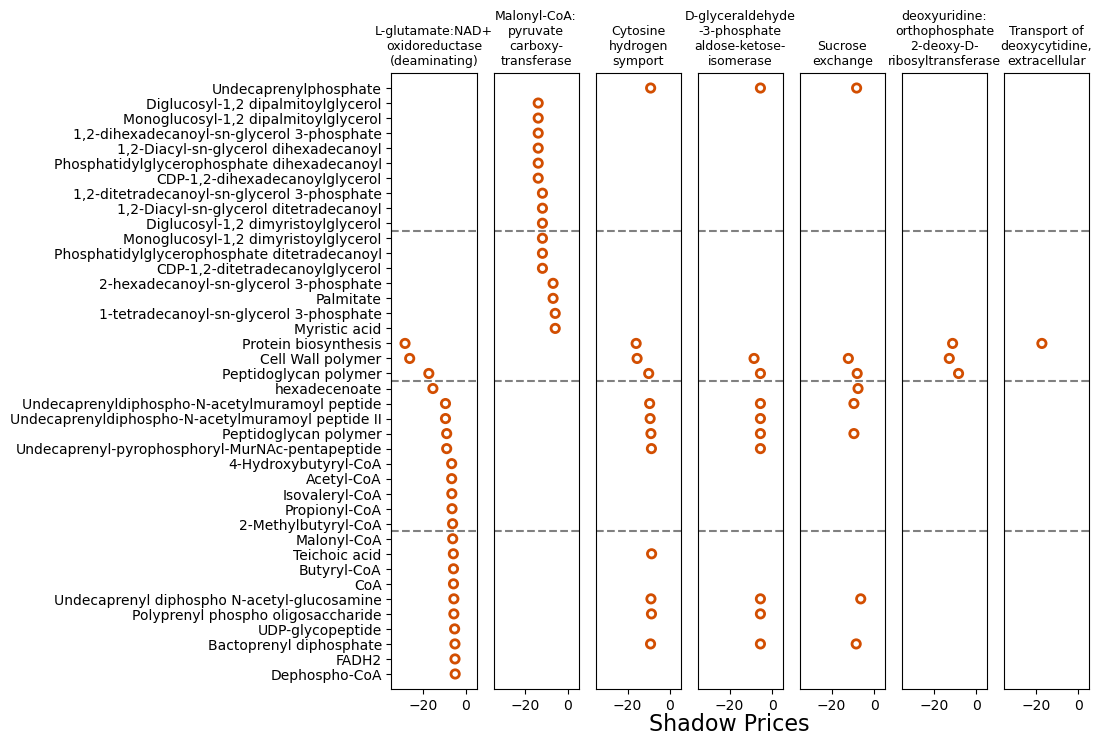

In [300]:
subtitles = ['L-glutamate:NAD+\noxidoreductase\n(deaminating)',
 'Malonyl-CoA:\npyruvate\ncarboxy-\ntransferase',
 'Cytosine\nhydrogen\nsymport',
 'D-glyceraldehyde\n-3-phosphate\naldose-ketose-\nisomerase',
 'Sucrose\nexchange',
 'deoxyuridine:\northophosphate\n2-deoxy-D-\nribosyltransferase',
 'Transport of\ndeoxycytidine,\nextracellular']

f, ax = plt.subplots(1,7, figsize = (9,8), sharey=True, sharex=True)

for x,OF in enumerate(of2):
    ax[x].scatter(ofdf4[OF], ofdf4.index, facecolors='none', edgecolors='#d24e01', linewidth=2)
    ax[x].set_title(subtitles[x], fontsize=9)
    ax[x].set_xlim(-30,0)
    ax[x].axhline(y=9.5, color='grey', linestyle='--')
    ax[x].axhline(y=19.5, color='grey', linestyle='--')
    ax[x].axhline(y=29.5, color='grey', linestyle='--')
    
# Remove ticks:
for x in range(1,7):
    ax[x].get_yaxis().set_visible(False)
    
locs, labels = plt.yticks()    
plt.yticks(locs,ofdf1.loc[ofdf4.index,'name'].tolist()) ; 
plt.suptitle('Shadow Prices', y = 0.08, fontsize = 16)
plt.xlim(-35,5)
plt.ylim(-1,40)

#plt.savefig('../figures/sp3_OF2.jpeg',bbox_inches='tight', dpi = 600)

# SCRATCHWORK

In [5]:
cpd00051_c

KeyError: 'L-arginine'

In [17]:
sp['cpd00051_c']

0      True
1      True
2      True
3      True
4      True
       ... 
272    True
273    True
274    True
275    True
276    True
Name: cpd00051_c, Length: 277, dtype: bool

In [27]:
sp.iloc[sp['cpd00051_c'].dropna(axis=0, how='any').index][['strain','condition','toxin','OF_name','cpd00051_c']]

,strain,condition,toxin,OF_name,cpd00051_c
88,CD630,BHIS + 120uM Deoxycholate,High,glycine synthase,-7.890844e-04
89,CD630,BHIS + 120uM Deoxycholate,High,UTP:alpha-D-glucose-1-phosphate uridylyltransf...,-9.906967e-07
95,CD630,BHIS + 120uM Deoxycholate,High,Glucose-1-phosphate transport via phosphate an...,-9.906967e-07
97,CD630,BHIS + 120uM Deoxycholate,High,"5,10-Methylenetetrahydrofolate:glycine hydroxy...",-5.002462e-04
107,CD630,BHIS + 240uM Deoxycholate,Low,glycine synthase,-1.264129e-04
116,CD630,BHIS + 240uM Deoxycholate,Low,"5,10-Methylenetetrahydrofolate:glycine hydroxy...",-8.004336e-05
194,CDR20291,Cholate,Low,glycine synthase,-3.659909e-05
203,CDR20291,Cholate,Low,"5,10-Methylenetetrahydrofolate:glycine hydroxy...",-2.317417e-05
206,CDR20291,Cholate,Low,diphosphate phosphohydrolase,-9.130362e-04
207,CDR20291,Cholate,Low,UDP-N-acetyl-D-glucosamine 2-epimerase,-1.487411e-06
